# Pré-processamento dos dados

In [14]:
# Importando as bibliotecas 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [15]:
# Carregando o arquivo 
# O dataset contém 43 colunas: 42 features + label
dataset = pd.read_csv("../Dados/classes-reduced.csv")

# Tratamento da label: No smell (0), AR (1), ET (2), CTL (3), VT (4) 
dataset['CLASS'] = dataset['CLASS'].replace('No smell',0)
dataset['CLASS'] = dataset['CLASS'].replace('AR',1)
dataset['CLASS'] = dataset['CLASS'].replace('ET',2)
dataset['CLASS'] = dataset['CLASS'].replace('CTL',3)
dataset['CLASS'] = dataset['CLASS'].replace('VT',4)

In [16]:
# Substituindo NaNs por media dos valores da coluna
allColumnsWithoutLabel = dataset.columns[:-1]
for column in allColumnsWithoutLabel:
    dataset[column] = dataset[column].fillna(dataset[column].mean())

In [ ]:
# Descriptive statistics
dataset.describe()

In [ ]:
# Boxplot de todo o dataset
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.boxplot(data=dataset, orient="h", palette="Set2")

In [17]:
# Outliers imputation tecnique utilizando outliers do boxplot
def imputation():
    for column in allColumnsWithoutLabel:
        remove_out = np.where(np.in1d(dataset[column], 
                                    boxplot_stats(dataset[column]).pop(0)['fliers']))
        dataset.loc[remove_out[0], column] = dataset[column].mean()

# Imputation Luana
def imputation2():
    for column in allColumnsWithoutLabel:
        outliers_index_list = np.where(np.in1d(dataset[column], boxplot_stats(dataset[column]).pop(0)['fliers']))
        q3 = dataset[column].quantile(0.9)
        q1 = dataset[column].quantile(0.1)
        print(q3)
        print(q1)
        for i in outliers_index_list[0]:
            instance_value = dataset[column].loc[i]
            if instance_value > q3:
                print(instance_value, "to", q3)
                dataset[column] = dataset[column].replace(instance_value, q3)
            if instance_value < q1:
                dataset[column] = dataset[column].replace(instance_value, q1)

# Imputation considerando substituição de maximo e minimo nos outliers
def imputation3():
    for column in allColumnsWithoutLabel:
        index = 0
        count = 0
        mean = 0

        outliers_list = np.where(np.in1d(dataset[column], boxplot_stats(dataset[column]).pop(0)['fliers']))
        datasetWithoutOutliers = dataset.drop(dataset.index[[outliers_list[0]]])
        maxValue = datasetWithoutOutliers[column].max() - 1
        minValue = datasetWithoutOutliers[column].min() + 1
        for i in outliers_list[0]:
            instanceValue = dataset.loc[i, column]
            if(instanceValue > maxValue):
                dataset.loc[i, column] = maxValue
            elif(instanceValue < minValue):
                dataset.loc[i, column] = minValue

In [18]:
# Aplicando Imputation
imputation3()

In [19]:
# Estas são as métricas que não estão totalmente balanceadas, por isso acabei removendo, dependendo podemos substituir por outras
dataset = dataset.drop(['comparisonsQty'], axis=1)
dataset = dataset.drop(['parenthesizedExpsQty'], axis=1)
dataset = dataset.drop(['lambdasQty'], axis=1)

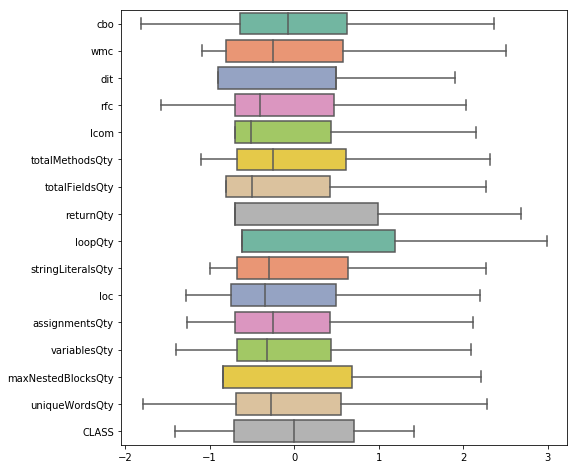

In [20]:
# Normalizando dataset e plotando boxplot novamente
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler().fit(dataset)
scaler = StandardScaler().fit(dataset)
norm_subset = pd.DataFrame(scaler.transform(dataset), columns = dataset.columns)
a = round(norm_subset.describe(), 2)

fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.boxplot(data=norm_subset, orient="h", palette="Set2")

In [ ]:
# Só vendo as correlações
#corr = norm_subset.corr(method='spearman').iloc[0:42, 42:]
corr = dataset.corr(method='spearman')

fig, ax = plt.subplots(figsize=(25,25))
    
ax = sns.heatmap(
    corr, 
    linewidths=.8,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=False
)
plt.ylabel('Class under test metrics')
plt.xlabel('Test smells instances')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)

# Aplicando algoritmos de classificação

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# Atualizando classe dos dados normalizados com a classe original
norm_subset["CLASS"] = dataset["CLASS"]

In [23]:
# Dividindo o dataset para treinamento
class_column = norm_subset['CLASS']
norm_subset = norm_subset.drop(['CLASS'], axis = 1)
X_train,X_test,y_train,y_test = train_test_split(norm_subset, class_column, test_size=0.1, random_state=23, 
                                                 stratify=class_column, shuffle=True)

In [24]:
lazy = KNeighborsClassifier(n_neighbors = 3, weights="distance", metric="euclidean")

In [25]:
lazy.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [26]:
lazy.score(X_test, y_test)

0.92

In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Preparando os modelos
kfold = model_selection.KFold(n_splits=10, random_state=23)
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = KNeighborsClassifier(n_neighbors = 3, metric="euclidean")
estimators.append(('knn', model2))
model3 = DecisionTreeClassifier()
estimators.append(('tree', model3))
model4 = SVC()
estimators.append(('svm', model4))
model5 = KNeighborsClassifier(n_neighbors = 3, weights="distance", metric="euclidean")
estimators.append(('dwnn', model5))

#ensemble = VotingClassifier(estimators)
#results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=kfold)

# Verificando score de todos so modelos
results = []
names = []
for name, model in estimators:
    kfold = model_selection.KFold(n_splits=10, random_state=23)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    print("%s: media %f | DP %f" % (name, cv_results.mean(), cv_results.std()))

# Plotando boxplot dos resultados
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

TypeError: not enough arguments for format string